In [1]:
# dataset
from keras.datasets import cifar10

import joblib
import numpy as np
import cv2 as cv
from skimage.feature import hog

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# utilities
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# models
from sklearn.cluster import MiniBatchKMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


# 1. Load Data

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank"> CIFAR-10 </a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [2]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [3]:
X_train = X_train.astype('uint8')
X_test = X_test.astype('uint8')

In [4]:
print(f'Total train data: {X_train.shape[0]}')
print(f'Total test data: {X_test.shape[0]}')
print(f'Image dimensions: {X_train.shape[1], X_train.shape[2], X_train.shape[3]}')

Total train data: 50000
Total test data: 10000
Image dimensions: (32, 32, 3)


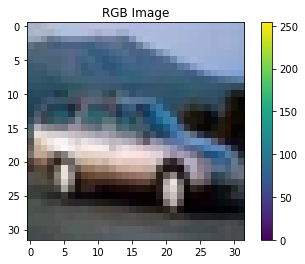

In [5]:
plt.imshow(X_train[4])

plt.title('RGB Image')
plt.colorbar()

# 2. Preprocessing

The following transformations are tested:
* grayscaling
* <span style="color:red"><b>(deprecated)</b></span> normalization (from [0, 255] to [0, 1] by dividing with 255)
* <span style="color:red"><b>(deprecated)</b></span> minmax scaling (from [0, 255] to [0, 1] using the formula: y = (x – min) / (max – min))
* <span style="color:red"><b>(deprecated)</b></span> standardization (y = (x - mean) / std), cliping to [-1, 1] and rescaling to [0, 1] with 0.5 mean (y = (x + 1.0) / 2.0)

## 2.1 Grayscale

In [6]:
def to_grayscale(data):
    """ Converts RGB images to grayscale.
    
    Args:
        data:
            images in RGB format, as numpy array.
    
    Returns:
       grayscale images, as numpy array.
    """
    grayscale = np.zeros((data.shape[0], data.shape[1], data.shape[2])).astype('uint8')
    
    for idx in range(data.shape[0]):
        grayscale[idx] = cv.cvtColor(data[idx], cv.COLOR_RGB2GRAY)
    
    return grayscale

In [7]:
X_train_grayscale = to_grayscale(X_train)
X_test_grayscale = to_grayscale(X_test)

In [8]:
print(f'Image dimensions in grayscale: {X_train_grayscale.shape[1], X_train_grayscale.shape[2]}')

Image dimensions in grayscale: (32, 32)


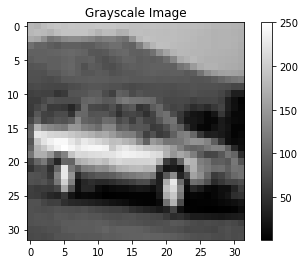

In [9]:
plt.imshow(X_train_grayscale[4], cmap='gray')

plt.title('Grayscale Image')
plt.colorbar()

## 2.2 Normalize

In [10]:
X_train_norm = X_train_grayscale / 255.0
X_test_norm = X_test_grayscale / 255.0

In [11]:
print(f'Image pixels after normalization:\n{X_train_norm[4]}')

Image pixels after normalization:
[[0.70196078 0.69411765 0.7254902  ... 0.69803922 0.69019608 0.68627451]
 [0.70196078 0.71764706 0.70980392 ... 0.69019608 0.68235294 0.6745098 ]
 [0.65490196 0.63529412 0.55686275 ... 0.69411765 0.68627451 0.6745098 ]
 ...
 [0.31764706 0.32156863 0.3254902  ... 0.29019608 0.27843137 0.25098039]
 [0.29019608 0.29411765 0.30196078 ... 0.30980392 0.29019608 0.29019608]
 [0.28627451 0.29019608 0.28627451 ... 0.30588235 0.29019608 0.29803922]]


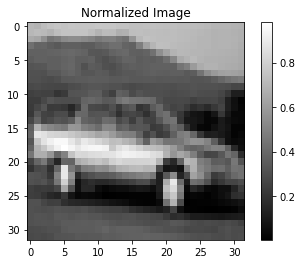

In [12]:
plt.imshow(X_train_norm[4], cmap='gray')

plt.title('Normalized Image')
plt.colorbar()

## 2.3 Minmax Scale

In [13]:
# min and max of train dataset
minimum = X_train_grayscale.min()
maximum = X_train_grayscale.max()

print(f'mean: {minimum}, std: {maximum}')

mean: 0, std: 255


In [14]:
# minmax scale
X_train_scale = (X_train_grayscale - minimum) / (maximum - minimum)
X_test_scale = (X_test_grayscale - minimum) / (maximum - minimum)

In [15]:
print(f'Image pixels after minmax scaling:\n{X_train_scale[4]}')

Image pixels after minmax scaling:
[[0.70196078 0.69411765 0.7254902  ... 0.69803922 0.69019608 0.68627451]
 [0.70196078 0.71764706 0.70980392 ... 0.69019608 0.68235294 0.6745098 ]
 [0.65490196 0.63529412 0.55686275 ... 0.69411765 0.68627451 0.6745098 ]
 ...
 [0.31764706 0.32156863 0.3254902  ... 0.29019608 0.27843137 0.25098039]
 [0.29019608 0.29411765 0.30196078 ... 0.30980392 0.29019608 0.29019608]
 [0.28627451 0.29019608 0.28627451 ... 0.30588235 0.29019608 0.29803922]]


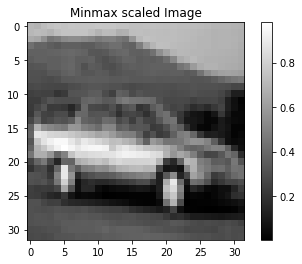

In [16]:
plt.imshow(X_train_scale[4], cmap='gray')

plt.title('Minmax scaled Image')
plt.colorbar()

## 2.4 Standardize, Clip, Rescale

In [17]:
# mean and std of train dataset
u = X_train_grayscale.mean()
s = X_train_grayscale.std()

print(f'mean: {u}, std: {s}')

mean: 122.6199244921875, std: 60.9935981511246


In [18]:
# standardize
X_train_stand = (X_train_grayscale - u) / s
X_test_stand = (X_test_grayscale - u) / s

# clip to [-1, 1]
X_train_stand = np.clip(X_train_stand, -1.0, 1.0)
X_test_stand = np.clip(X_test_stand, -1.0, 1.0)

# rescale to [0, 1] with 0.5 mean
X_train_stand = (X_train_stand + 1.0) / 2.0
X_test_stand = (X_test_stand + 1.0) / 2.0

In [19]:
print(f'Image pixels after standardization, cliping and rescaling:\n{X_train_stand[4]}')

Image pixels after standardization, cliping and rescaling:
[[0.96218027 0.94578511 1.         ... 0.95398269 0.93758753 0.92938994]
 [0.96218027 0.9949706  0.97857543 ... 0.93758753 0.92119236 0.9047972 ]
 [0.86380929 0.82282138 0.65886975 ... 0.94578511 0.92938994 0.9047972 ]
 ...
 [0.15881727 0.16701485 0.17521243 ... 0.1014342  0.07684146 0.01945838]
 [0.1014342  0.10963178 0.12602694 ... 0.14242211 0.1014342  0.1014342 ]
 [0.09323662 0.1014342  0.09323662 ... 0.13422453 0.1014342  0.11782936]]


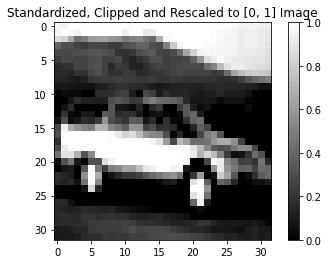

In [20]:
plt.imshow(X_train_stand[4], cmap='gray')

plt.title('Standardized, Clipped and Rescaled to [0, 1] Image')
plt.colorbar()

# 3. Features

The following features are extracted from images:
* <a href="https://docs.opencv.org/4.5.2/d1/db7/tutorial_py_histogram_begins.html" target="_blank"> Gray Color Histogram (GCH) </a>
* <a href="https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html" target="_blank"> Histogram of Oriented Gradients (HOG) </a>
* <a href="https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html" target="_blank"> Scale-Invariant Feature Transform (SIFT) </a>

## 3.1 Gray Color Histogram

In [21]:
def color_histogram(data):
    """ Extracts gray color histograms.
    
    Args:
        data:
            images in grayscale format, as numpy array.
    
    Returns:
        gray color histograms, as list of numpy arrays.
    """
    color_hists = []
    
    for idx in range(data.shape[0]):
        color_hist = cv.calcHist([data[idx]], [0], None, [256], [0,256])
        color_hists.append(color_hist.ravel())
    
    return color_hists

In [22]:
color_hist_train = color_histogram(X_train_grayscale)
color_hist_test = color_histogram(X_test_grayscale)

In [23]:
print(f'Image gray color histogram, first 10 values: {color_hist_train[4][:10]}\n') 
print(f'Size of image gray color histogram: {color_hist_train[4].shape}')

Image gray color histogram, first 10 values: [ 0.  4.  4.  6. 10.  6.  3.  4.  6.  7.]

Size of image gray color histogram: (256,)


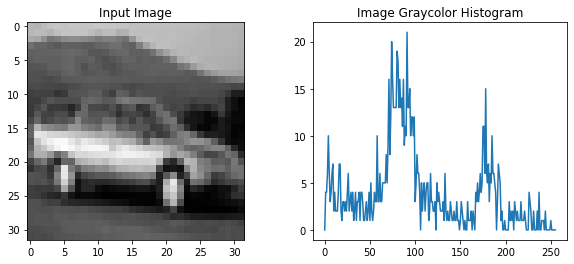

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.imshow(X_train_grayscale[4], cmap='gray')
ax1.set_title('Input Image')

ax2.plot(color_hist_train[4]); 
ax2.set_title('Image Graycolor Histogram')

plt.show()

## 3.2 Histogram of Oriented Gradients (HOG)

In [25]:
def hog_features(data):
    """ Extracts histogram of oriented gradients.
    
    Args:
        data:
            images in grayscale format, as numpy array.
    
    Returns:
        HOG descriptors, as list of numpy arrays.
        HOG images, as list of numpy arrays.
    """
    hog_descriptors = []
    hog_images = []
    
    for idx in range(data.shape[0]):
        fd, hog_image = hog(data[idx], 
                            orientations=9, 
                            pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), 
                            block_norm='L2-Hys',
                            transform_sqrt=True,
                            feature_vector=True,
                            visualize=True)  
        hog_descriptors.append(fd)
        hog_images.append(hog_image)
    
    return hog_descriptors, hog_images

In [26]:
hog_train, hog_train_img = hog_features(X_train_grayscale)
hog_test, hog_test_img = hog_features(X_test_grayscale)

In [27]:
print(f'Image HOG, first 6 values: {hog_train[4][:6]}\n')
print(f'Size of image HOG: {hog_train[4].shape}')

Image HOG, first 6 values: [0.05613025 0.01108392 0.0912732  0.1247402  0.29826597 0.27952999]

Size of image HOG: (324,)


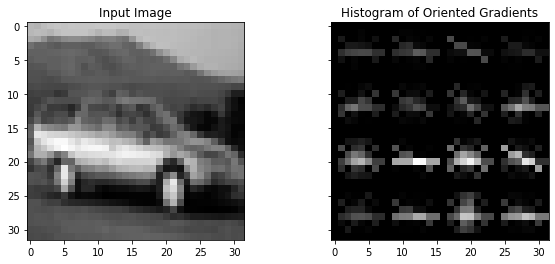

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

ax1.imshow(X_train_grayscale[4], cmap='gray')
ax1.set_title('Input Image')

ax2.imshow(hog_train_img[4], cmap='gray')
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

## 3.3 Scale-Invariant Feature Transform (SIFT)

In [29]:
def sift_features(data):
    """ Extracts image SIFT keypoints and descriptors.
    
    Args:
        data:
            images in grayscale format, as numpy array.
    
    Returns:
        SIFT keypoints, as list of lists.
        SIFT descriptors, as list of numpy array. 
    """
    sift = cv.xfeatures2d.SIFT_create(contrastThreshold=0.02, sigma=0.9)
    
    keypoints = []
    descriptors = []
    
    for idx in range(data.shape[0]):
        kp, des = sift.detectAndCompute(data[idx], None)
        keypoints.append(kp)
        descriptors.append(des)
    
    return keypoints, descriptors

In [30]:
kp_sift_train, des_sift_train = sift_features(X_train_grayscale) 
kp_sift_test, des_sift_test = sift_features(X_test_grayscale)

In [31]:
print(f'Image SIFT keypoints, first 3 values: {kp_sift_train[4][:3]}\n')
print(f'Size SIFT keypoints (image 4): {len(kp_sift_train[4])}')
print(f'Size SIFT keypoints (image 8): {len(kp_sift_train[8])}')

Image SIFT keypoints, first 3 values: [<KeyPoint 000001B80218E390>, <KeyPoint 000001B80218E3C0>, <KeyPoint 000001B80218E3F0>]

Size SIFT keypoints (image 4): 37
Size SIFT keypoints (image 8): 30


In [32]:
print(f'Image SIFT descriptors:\n{des_sift_train[4]}\n')

print(f'Size SIFT descriptors (image 4): {des_sift_train[4].shape}')
print(f'Size SIFT descriptors (image 8): {des_sift_train[8].shape}')

Image SIFT descriptors:
[[ 27.   1.   0. ...   0.   0.   0.]
 [  0.   3.   1. ...  21.   0.   0.]
 [ 11.   7.   2. ...   9.   0.   3.]
 ...
 [ 37.   0.   0. ...   0.   6.  26.]
 [ 44.  45.  24. ...   1. 101.  33.]
 [  9.  76.  43. ...   0.   0.   0.]]

Size SIFT descriptors (image 4): (37, 128)
Size SIFT descriptors (image 8): (30, 128)


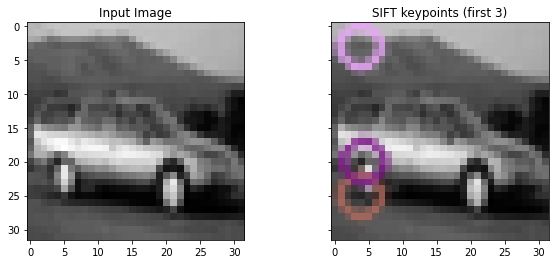

In [33]:
img = cv.drawKeypoints(X_train_grayscale[4], kp_sift_train[4][:3], None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

ax1.imshow(X_train_grayscale[4], cmap='gray')
ax1.set_title('Input Image')

ax2.imshow(img, cmap='gray')
ax2.set_title('SIFT keypoints (first 3)')

plt.show()

# 4. Bag of Visual Words (BoVW) model

We'll only insert SIFT features into the BoVW model, since GCH and HOG features are already in histogram forms.

To evaluate our BoVW, we'll use the **Elbow method** along with the **Davies-Bouldin Index** metric.

## 4.1 Visual Vocabulary

In [27]:
def get_visual_words(descriptors, model):
    """ Finds the vocabulary of visual words.

    To find the vocabulary of visual words, k-means is used. The centroids found by k-means
    form the vocabulary.

    Args:
        descriptors:
            descriptors, as list of numpy arrays.
        model:
            clustering model, as scikit-learn object.

    Returns:
        fitted k-means, holding the vocabulary of visual words .
    """
    
    visual_words = model.fit(descriptors)

    return visual_words

In [28]:
des_sift_raw_train = []
for des in des_sift_train:
    if des is not None:
        des_sift_raw_train.extend(des)

In [29]:
batch_kmeans_score = []

for n_clusters in range(100, 1100, 100):
    print(f'Number of clusters: {n_clusters}')
    
    clustering = MiniBatchKMeans(n_clusters=n_clusters, batch_size=64, n_init=10, max_iter=300)
    model = get_visual_words(descriptors=des_sift_raw_train, model=clustering)
    
    batch_kmeans_score.append(davies_bouldin_score(des_sift_raw_train, model.labels_))

Number of clusters: 100
Number of clusters: 200
Number of clusters: 300
Number of clusters: 400
Number of clusters: 500
Number of clusters: 600
Number of clusters: 700
Number of clusters: 800
Number of clusters: 900
Number of clusters: 1000


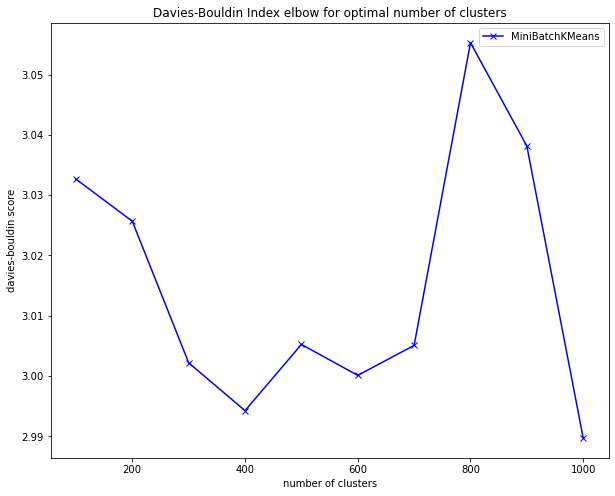

number of clusters: 100 | MiniBatchKMeans: 3.03267504551066
number of clusters: 200 | MiniBatchKMeans: 3.0256724349067996
number of clusters: 300 | MiniBatchKMeans: 3.0021796838443287
number of clusters: 400 | MiniBatchKMeans: 2.9942425789378
number of clusters: 500 | MiniBatchKMeans: 3.0052330048211524
number of clusters: 600 | MiniBatchKMeans: 3.000097808607382
number of clusters: 700 | MiniBatchKMeans: 3.005075066588511
number of clusters: 800 | MiniBatchKMeans: 3.0553085694010953
number of clusters: 900 | MiniBatchKMeans: 3.0381537926051556
number of clusters: 1000 | MiniBatchKMeans: 2.989699625014526


In [30]:
plt.figure(figsize=(10,8))

plt.plot(range(100, 1100, 100), batch_kmeans_score, 'bx-', label='MiniBatchKMeans')

plt.xlabel('number of clusters')
plt.ylabel('davies-bouldin score')
plt.title('Davies-Bouldin Index elbow for optimal number of clusters')
plt.legend()

plt.show()

for count, value in enumerate(range(100, 1100, 100)):
    print(f'number of clusters: {value} | MiniBatchKMeans: {batch_kmeans_score[count]}')

In [31]:
# retrain best model (the best model has the lowest davies-bouldin score)
bovw = get_visual_words(descriptors=des_sift_raw_train, 
                        model=MiniBatchKMeans(n_clusters=400, batch_size=64, n_init=10, max_iter=300))

# save model
with open('..\\saved-model\\bovw.joblib', 'wb') as f:
    joblib.dump(bovw, f)

['bovw.joblib']

## 4.2 Vector Representations

In [34]:
def get_vector_representation(model, descriptors):
    """ Computes the vector representations of images.

    The representations are based on the images descriptors and a predefined BoVW model. Specifically,
    they're a histogram of the frequencies of visual words from the vocabulary of the BoVW.

    Args:
        model:
            precomputed BoVW model, as scikit-learn obj.
        descriptors:
            descriptors, as list of numpy arrays.

    Returns:
        vector representations of images, as list of numpy array.
    """
    histograms = []
    for desc in descriptors:
        hist = np.zeros(model.cluster_centers_.shape[0])
        if desc is not None:
            for d in desc:
                # find the cluster each descriptor is close to
                cluster_idx = model.predict([d.astype(float)])
                hist[cluster_idx] += 1
            histograms.append(hist)
    
    return histograms

In [35]:
with open('..\\saved-model\\bovw.joblib', 'rb') as f:
    bovw = joblib.load(f)

In [36]:
des_sift_train = get_vector_representation(bovw, des_sift_train)
des_sift_test = get_vector_representation(bovw, des_sift_test)

# 5. Early Fusion

Since **Histogram of Oriented Gradients (HOG)** are the most popular features for computer vision tasks (like classification), we'll only create combinations that include them. The combinations are:
* HOG + GCH
* HOG + SIFT
* HOG + GCH + SIFT

## 5.1 Early Fusion: HOG + GCH

In [37]:
hog_gch_train = []
for idx in range(X_train_grayscale.shape[0]):
    fused = np.concatenate((hog_train[idx], color_hist_train[idx]), axis=None)
    hog_gch_train.append(fused)

hog_gch_test = []
for idx in range(X_test_grayscale.shape[0]):
    fused = np.concatenate((hog_test[idx], color_hist_test[idx]), axis=None)
    hog_gch_test.append(fused)

In [38]:
print(f'Number of features: {hog_gch_train[0].shape[0]}')

Number of features: 580


## 5.2 Early Fusion: HOG + SIFT

In [39]:
hog_sift_train = []
for idx in range(X_train_grayscale.shape[0]):
    fused = np.concatenate((hog_train[idx], des_sift_train[idx]), axis=None)
    hog_sift_train.append(fused)

hog_sift_test = []
for idx in range(X_test_grayscale.shape[0]):
    fused = np.concatenate((hog_test[idx], des_sift_test[idx]), axis=None)
    hog_sift_test.append(fused)

In [40]:
print(f'Number of features: {hog_sift_train[0].shape[0]}')

Number of features: 724


## 5.3 Early Fusion: HOG + GCH + SIFT

In [41]:
hog_gch_sift_train = []
for idx in range(X_train_grayscale.shape[0]):
    fused = np.concatenate((hog_train[idx], color_hist_train[idx]), axis=None)
    fused = np.concatenate((fused, des_sift_train[idx]), axis=None)
    hog_gch_sift_train.append(fused)

hog_gch_sift_test = []
for idx in range(X_test_grayscale.shape[0]):
    fused = np.concatenate((hog_test[idx], color_hist_test[idx]), axis=None)
    fused = np.concatenate((fused, des_sift_test[idx]), axis=None)
    hog_gch_sift_test.append(fused)

In [42]:
print(f'Number of features: {hog_gch_sift_train[0].shape[0]}')

Number of features: 980


# 6. Classification

The primary **metric** we'll use to validate our models will be **accuracy**, since CIFAR-10 is a well balanced dataset. 

Other metrics that are worth looking at are **precision** and **recall**, since the models will be used for retreval tasks.

The models we'll use for classification are:
* Gaussian Naive Bayes
* Logistic Regression
* k Nearest Neighbors
* Linear SVM
* Random Forest

In [43]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## 6.1 Gaussian Naive Bayes

| Features         | Train Accuracy | Test Acurracy |
| :--------------: | :------------: | :-----------: |
| HOG + GCH        | 37%            | 37%           |
| HOG + SIFT       | 39%            | 37%           |
| HOG + GCH + SIFT | 40%            | 37%           |

### 6.1.1 Gaussian NB: HOG + GCH

In [44]:
clf = GaussianNB()

clf.fit(hog_gch_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_gch_train)
Y_test_pred = clf.predict(hog_gch_test)

In [45]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.48      0.35      0.40      5000
  automobile       0.45      0.52      0.48      5000
        bird       0.41      0.17      0.24      5000
         cat       0.26      0.14      0.18      5000
        deer       0.25      0.46      0.32      5000
         dog       0.35      0.41      0.38      5000
        frog       0.37      0.45      0.41      5000
       horse       0.48      0.23      0.31      5000
        ship       0.40      0.39      0.39      5000
       truck       0.41      0.62      0.49      5000

    accuracy                           0.37     50000
   macro avg       0.39      0.37      0.36     50000
weighted avg       0.39      0.37      0.36     50000

Test:
              precision    recall  f1-score   support

    airplane       0.47      0.35      0.40      1000
  automobile       0.47      0.49      0.48      1000
        bird       0.38      0.16      0.23      1000
         ca

### 6.1.2 Gaussian NB: HOG + SIFT

In [47]:
clf = GaussianNB()

clf.fit(hog_sift_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_sift_train)
Y_test_pred = clf.predict(hog_sift_test)

In [48]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.42      0.58      0.49      5000
  automobile       0.51      0.35      0.41      5000
        bird       0.25      0.37      0.30      5000
         cat       0.33      0.24      0.28      5000
        deer       0.35      0.17      0.23      5000
         dog       0.45      0.34      0.39      5000
        frog       0.40      0.55      0.46      5000
       horse       0.47      0.31      0.37      5000
        ship       0.37      0.61      0.46      5000
       truck       0.51      0.41      0.46      5000

    accuracy                           0.39     50000
   macro avg       0.41      0.39      0.38     50000
weighted avg       0.41      0.39      0.38     50000

Test:
              precision    recall  f1-score   support

    airplane       0.40      0.56      0.47      1000
  automobile       0.47      0.31      0.38      1000
        bird       0.22      0.33      0.26      1000
         ca

### 6.1.3 Gaussian NB: HOG + GCH + SIFT

In [50]:
clf = GaussianNB()

clf.fit(hog_gch_sift_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_gch_sift_train)
Y_test_pred = clf.predict(hog_gch_sift_test)

In [51]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.45      0.45      0.45      5000
  automobile       0.47      0.49      0.48      5000
        bird       0.40      0.19      0.26      5000
         cat       0.29      0.22      0.25      5000
        deer       0.29      0.37      0.33      5000
         dog       0.39      0.43      0.41      5000
        frog       0.40      0.50      0.45      5000
       horse       0.47      0.30      0.37      5000
        ship       0.39      0.50      0.44      5000
       truck       0.43      0.53      0.47      5000

    accuracy                           0.40     50000
   macro avg       0.40      0.40      0.39     50000
weighted avg       0.40      0.40      0.39     50000

Test:
              precision    recall  f1-score   support

    airplane       0.43      0.45      0.44      1000
  automobile       0.44      0.42      0.43      1000
        bird       0.34      0.16      0.22      1000
         ca

## 6.2 Logistic Regression

| Features         | Train Accuracy | Test Acurracy | Train Precision | Test Precision |
| :--------------: | :------------: | :-----------: | :-------------: | :------------: | 
| HOG + GCH        | 56%            | 52%           | 55%             | 52%            |
| HOG + SIFT       | 60%            | 56%           | 59%             | 56%            |
| HOG + GCH + SIFT | 61%            | 56%           | 61%             | 55%            |

In [44]:
model = Pipeline([
    ('clf', LogisticRegression(max_iter=5000))
])

In [45]:
# hyperparameter space
parameters = {
    'clf__C': [1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}

### 6.2.1 LR: HOG + GCH

In [46]:
# hyperparameter tunning & cross validation
grid = GridSearchCV(model, parameters, scoring="accuracy", cv=5, verbose=10)
results = grid.fit(hog_gch_train, Y_train.ravel())

print(f'Best grid search accuracy score: {results.best_score_}')
print(f'Best grid search parameters: {results.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... clf__C=0.0001, score=0.217, total=  13.9s
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s


[CV] ....................... clf__C=0.0001, score=0.212, total=  13.7s
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.5s remaining:    0.0s


[CV] ....................... clf__C=0.0001, score=0.211, total=  14.7s
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   42.1s remaining:    0.0s


[CV] ....................... clf__C=0.0001, score=0.204, total=  14.4s
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   56.5s remaining:    0.0s


[CV] ....................... clf__C=0.0001, score=0.209, total=  13.9s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.351, total=  37.3s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.8min remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.347, total=  35.0s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.4min remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.347, total=  39.0s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.0min remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.338, total=  37.2s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.6min remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.346, total=  36.4s
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.480, total= 1.9min
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.479, total= 1.8min
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.483, total= 1.7min
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.481, total= 1.8min
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.484, total= 1.7min
[CV] clf__C=0.1 ......................................................
[CV] .......................... clf__C=0.1, score=0.515, total= 4.8min
[CV] clf__C=0.1 ......................................................
[CV] .

C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .......................... clf__C=1.0, score=0.526, total= 5.5min
[CV] clf__C=1.0 ......................................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .......................... clf__C=1.0, score=0.519, total= 5.7min
[CV] clf__C=1.0 ......................................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .......................... clf__C=1.0, score=0.530, total= 6.5min
[CV] clf__C=1.0 ......................................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .......................... clf__C=1.0, score=0.523, total= 5.9min
[CV] clf__C=1.0 ......................................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 65.8min finished


[CV] .......................... clf__C=1.0, score=0.528, total= 5.6min
Best grid search accuracy score: 0.52512
Best grid search parameters: {'clf__C': 1.0}


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [53]:
# retrain best model
clf = LogisticRegression(C=1.0, max_iter=5000)

clf.fit(hog_gch_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_gch_train)
Y_test_pred = clf.predict(hog_gch_test)

C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [54]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.63      0.62      0.63      5000
  automobile       0.65      0.68      0.67      5000
        bird       0.49      0.43      0.46      5000
         cat       0.44      0.34      0.38      5000
        deer       0.45      0.48      0.46      5000
         dog       0.48      0.46      0.47      5000
        frog       0.55      0.65      0.59      5000
       horse       0.57      0.61      0.59      5000
        ship       0.63      0.63      0.63      5000
       truck       0.66      0.70      0.68      5000

    accuracy                           0.56     50000
   macro avg       0.56      0.56      0.56     50000
weighted avg       0.56      0.56      0.56     50000

Test:
              precision    recall  f1-score   support

    airplane       0.59      0.58      0.58      1000
  automobile       0.60      0.62      0.61      1000
        bird       0.46      0.41      0.44      1000
         ca

### 6.2.2 LR: HOG + SIFT

In [47]:
# hyperparameter tunning & cross validation
grid = GridSearchCV(model, parameters, scoring="accuracy", cv=5, verbose=10)
results = grid.fit(hog_sift_train, Y_train.ravel())

print(f'Best grid search accuracy score: {results.best_score_}')
print(f'Best grid search parameters: {results.best_params_}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] clf__C=0.0001 ...................................................
[CV] ....................... clf__C=0.0001, score=0.354, total=   2.7s
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] ....................... clf__C=0.0001, score=0.352, total=   2.2s
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s


[CV] ....................... clf__C=0.0001, score=0.356, total=   2.3s
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s


[CV] ....................... clf__C=0.0001, score=0.357, total=   2.2s
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.3s remaining:    0.0s


[CV] ....................... clf__C=0.0001, score=0.351, total=   2.3s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.5s remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.435, total=   6.6s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.1s remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.433, total=   6.6s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.7s remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.437, total=   7.5s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   32.2s remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.442, total=   5.6s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   37.9s remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.435, total=   7.4s
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.512, total=  16.4s
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.516, total=  14.8s
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.519, total=  15.2s
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.515, total=  15.2s
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.509, total=  14.9s
[CV] clf__C=0.1 ......................................................
[CV] .......................... clf__C=0.1, score=0.543, total=  33.9s
[CV] clf__C=0.1 ......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  9.9min finished


Best grid search accuracy score: 0.5511799999999999
Best grid search parameters: {'clf__C': 1.0}


In [55]:
# retrain best model
clf = LogisticRegression(C=1.0, max_iter=5000)

clf.fit(hog_sift_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_sift_train)
Y_test_pred = clf.predict(hog_sift_test)

In [56]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.66      0.65      0.66      5000
  automobile       0.69      0.71      0.70      5000
        bird       0.52      0.47      0.50      5000
         cat       0.46      0.40      0.43      5000
        deer       0.48      0.49      0.49      5000
         dog       0.53      0.53      0.53      5000
        frog       0.61      0.67      0.64      5000
       horse       0.62      0.64      0.63      5000
        ship       0.66      0.67      0.66      5000
       truck       0.69      0.72      0.71      5000

    accuracy                           0.60     50000
   macro avg       0.59      0.60      0.59     50000
weighted avg       0.59      0.60      0.59     50000

Test:
              precision    recall  f1-score   support

    airplane       0.62      0.63      0.63      1000
  automobile       0.65      0.67      0.66      1000
        bird       0.48      0.42      0.45      1000
         ca

### 6.2.3 LR: HOG + GCH + SIFT

In [48]:
# hyperparameter tunning & cross validation
grid = GridSearchCV(model, parameters, scoring="accuracy", cv=5, verbose=10)
results = grid.fit(hog_gch_sift_train, Y_train.ravel())

print(f'Best grid search accuracy score: {results.best_score_}')
print(f'Best grid search parameters: {results.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... clf__C=0.0001, score=0.290, total=  19.2s
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.1s remaining:    0.0s


[CV] ....................... clf__C=0.0001, score=0.291, total=  18.9s
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.0s remaining:    0.0s


[CV] ....................... clf__C=0.0001, score=0.287, total=  18.0s
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   55.9s remaining:    0.0s


[CV] ....................... clf__C=0.0001, score=0.281, total=  20.1s
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[CV] ....................... clf__C=0.0001, score=0.287, total=  22.0s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.431, total=  58.6s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.6min remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.423, total=  59.8s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.6min remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.425, total=  58.9s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.6min remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.424, total=  55.2s
[CV] clf__C=0.001 ....................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.5min remaining:    0.0s


[CV] ........................ clf__C=0.001, score=0.422, total=  54.5s
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.512, total= 2.3min
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.510, total= 2.4min
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.512, total= 2.5min
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.505, total= 2.4min
[CV] clf__C=0.01 .....................................................
[CV] ......................... clf__C=0.01, score=0.506, total= 2.5min
[CV] clf__C=0.1 ......................................................
[CV] .......................... clf__C=0.1, score=0.544, total= 6.1min
[CV] clf__C=0.1 ......................................................
[CV] .

C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .......................... clf__C=1.0, score=0.552, total= 7.6min
[CV] clf__C=1.0 ......................................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .......................... clf__C=1.0, score=0.544, total= 7.8min
[CV] clf__C=1.0 ......................................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .......................... clf__C=1.0, score=0.549, total= 7.7min
[CV] clf__C=1.0 ......................................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .......................... clf__C=1.0, score=0.551, total= 7.8min
[CV] clf__C=1.0 ......................................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 87.9min finished


[CV] .......................... clf__C=1.0, score=0.549, total= 8.0min
Best grid search accuracy score: 0.54898
Best grid search parameters: {'clf__C': 1.0}


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [57]:
# retrain best model
clf = LogisticRegression(C=1.0, max_iter=5000)

clf.fit(hog_gch_sift_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_gch_sift_train)
Y_test_pred = clf.predict(hog_gch_sift_test)

C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [58]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.67      0.66      0.66      5000
  automobile       0.70      0.73      0.72      5000
        bird       0.54      0.49      0.51      5000
         cat       0.48      0.42      0.45      5000
        deer       0.50      0.52      0.51      5000
         dog       0.55      0.55      0.55      5000
        frog       0.63      0.68      0.65      5000
       horse       0.64      0.66      0.65      5000
        ship       0.67      0.69      0.68      5000
       truck       0.70      0.73      0.72      5000

    accuracy                           0.61     50000
   macro avg       0.61      0.61      0.61     50000
weighted avg       0.61      0.61      0.61     50000

Test:
              precision    recall  f1-score   support

    airplane       0.60      0.60      0.60      1000
  automobile       0.65      0.66      0.65      1000
        bird       0.47      0.42      0.45      1000
         ca

## 6.3 k Nearest Neighbors

| Features         | Train Accuracy | Test Acurracy |
| :--------------: | :------------: | :-----------: |
| HOG + GCH        | 100%           | 23%           |
| HOG + SIFT       | 100%           | 19%           |
| HOG + GCH + SIFT | 100%           | 23%           |

In [44]:
model = Pipeline([
    ('clf', KNeighborsClassifier())
])

In [45]:
# hyperparameter space
parameters = {
    'clf__n_neighbors': [5, 10, 15, 20],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['minkowski', 'euclidean']
} 

### 6.3.1 kNN: HOG + GCH

In [47]:
# hyperparameter tunning & cross validation
grid = GridSearchCV(model, parameters, scoring="accuracy", cv=5, verbose=10)
results = grid.fit(hog_gch_train, Y_train.ravel())

print(f'Best grid search accuracy score: {results.best_score_}')
print(f'Best grid search parameters: {results.best_params_}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.202, total= 6.8min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.200, total= 6.7min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.5min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.206, total= 6.6min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.0min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.193, total= 6.8min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 26.8min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.194, total= 6.8min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 33.6min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.204, total= 6.8min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 40.4min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.202, total= 6.7min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 47.1min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.206, total= 6.7min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 53.8min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.195, total= 6.8min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 60.5min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.197, total= 6.2min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.215, total= 6.3min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.214, total= 7.0min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.214, total= 7.0min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.203, total= 6.8min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.211, total= 6.7min
[CV] clf__metric=minkowski, clf__n_neighbors=10, cl

[CV]  clf__metric=euclidean, clf__n_neighbors=10, clf__weights=distance, score=0.211, total= 6.7min
[CV] clf__metric=euclidean, clf__n_neighbors=10, clf__weights=distance 
[CV]  clf__metric=euclidean, clf__n_neighbors=10, clf__weights=distance, score=0.212, total= 6.8min
[CV] clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform 
[CV]  clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform, score=0.224, total= 6.9min
[CV] clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform 
[CV]  clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform, score=0.222, total= 6.9min
[CV] clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform 
[CV]  clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform, score=0.218, total= 6.8min
[CV] clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform 
[CV]  clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform, score=0.215, total= 6.8min
[CV] clf__metric=euclidean, clf__n_neighbors=15,

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 536.8min finished


Best grid search accuracy score: 0.22546
Best grid search parameters: {'clf__metric': 'minkowski', 'clf__n_neighbors': 20, 'clf__weights': 'distance'}


In [46]:
# retrain best model
clf = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='minkowski')

clf.fit(hog_gch_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_gch_train)
Y_test_pred = clf.predict(hog_gch_test)

In [47]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00      5000
  automobile       1.00      1.00      1.00      5000
        bird       1.00      1.00      1.00      5000
         cat       1.00      1.00      1.00      5000
        deer       1.00      1.00      1.00      5000
         dog       1.00      1.00      1.00      5000
        frog       1.00      1.00      1.00      5000
       horse       1.00      1.00      1.00      5000
        ship       1.00      1.00      1.00      5000
       truck       1.00      1.00      1.00      5000

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000

Test:
              precision    recall  f1-score   support

    airplane       0.36      0.21      0.26      1000
  automobile       0.25      0.27      0.26      1000
        bird       0.21      0.20      0.21      1000
         ca

### 6.3.2 kNN: HOG + SIFT

In [48]:
# hyperparameter tunning & cross validation
grid = GridSearchCV(model, parameters, scoring="accuracy", cv=5, verbose=10)
results = grid.fit(hog_sift_train, Y_train.ravel())

print(f'Best grid search accuracy score: {results.best_score_}')
print(f'Best grid search parameters: {results.best_params_}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.182, total= 9.2min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.2min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.185, total= 9.3min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 18.4min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.179, total= 9.1min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 27.6min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.171, total= 9.2min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 36.7min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.182, total= 9.1min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 45.9min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.197, total= 9.0min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 54.9min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.195, total= 9.0min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 63.9min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.195, total= 9.1min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 73.0min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.183, total= 9.1min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 82.1min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.197, total= 9.1min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.184, total= 9.1min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.184, total= 9.1min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.178, total= 9.1min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.176, total= 9.1min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.180, total= 9.1min
[CV] clf__metric=minkowski, clf__n_neighbors=10, cl

[CV]  clf__metric=euclidean, clf__n_neighbors=10, clf__weights=distance, score=0.185, total=10.9min
[CV] clf__metric=euclidean, clf__n_neighbors=10, clf__weights=distance 
[CV]  clf__metric=euclidean, clf__n_neighbors=10, clf__weights=distance, score=0.192, total=11.1min
[CV] clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform 
[CV]  clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform, score=0.186, total=10.9min
[CV] clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform 
[CV]  clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform, score=0.185, total=10.8min
[CV] clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform 
[CV]  clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform, score=0.179, total=10.8min
[CV] clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform 
[CV]  clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform, score=0.172, total=10.9min
[CV] clf__metric=euclidean, clf__n_neighbors=15,

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 790.6min finished


Best grid search accuracy score: 0.19348
Best grid search parameters: {'clf__metric': 'minkowski', 'clf__n_neighbors': 5, 'clf__weights': 'distance'}


In [48]:
# retrain best model
clf = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski')

clf.fit(hog_sift_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_sift_train)
Y_test_pred = clf.predict(hog_sift_test)

In [49]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00      5000
  automobile       1.00      1.00      1.00      5000
        bird       1.00      1.00      1.00      5000
         cat       1.00      1.00      1.00      5000
        deer       1.00      1.00      1.00      5000
         dog       1.00      1.00      1.00      5000
        frog       1.00      1.00      1.00      5000
       horse       1.00      1.00      1.00      5000
        ship       1.00      1.00      1.00      5000
       truck       1.00      1.00      1.00      5000

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000

Test:
              precision    recall  f1-score   support

    airplane       0.19      0.58      0.28      1000
  automobile       0.33      0.07      0.11      1000
        bird       0.14      0.23      0.18      1000
         ca

### 6.3.3 kNN: HOG + GCH + SIFT

In [49]:
# hyperparameter tunning & cross validation
grid = GridSearchCV(model, parameters, scoring="accuracy", cv=5, verbose=10)
results = grid.fit(hog_gch_sift_train, Y_train.ravel())

print(f'Best grid search accuracy score: {results.best_score_}')
print(f'Best grid search parameters: {results.best_params_}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.200, total=12.2min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.2min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.204, total=12.0min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 24.3min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.206, total=12.0min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 36.3min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.198, total=11.8min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 48.0min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=uniform, score=0.196, total=12.1min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 60.2min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.203, total=12.1min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 72.3min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.206, total=12.1min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 84.4min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.206, total=12.1min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 96.4min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.198, total=12.0min
[CV] clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 108.4min remaining:    0.0s


[CV]  clf__metric=minkowski, clf__n_neighbors=5, clf__weights=distance, score=0.201, total=12.1min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.222, total=12.5min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.216, total=12.4min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.215, total=12.4min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.205, total=12.3min
[CV] clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform 
[CV]  clf__metric=minkowski, clf__n_neighbors=10, clf__weights=uniform, score=0.212, total=12.4min
[CV] clf__metric=minkowski, clf__n_neighbors=10, cl

[CV]  clf__metric=euclidean, clf__n_neighbors=10, clf__weights=distance, score=0.211, total=10.1min
[CV] clf__metric=euclidean, clf__n_neighbors=10, clf__weights=distance 
[CV]  clf__metric=euclidean, clf__n_neighbors=10, clf__weights=distance, score=0.214, total=10.1min
[CV] clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform 
[CV]  clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform, score=0.226, total=10.2min
[CV] clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform 
[CV]  clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform, score=0.224, total=10.2min
[CV] clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform 
[CV]  clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform, score=0.220, total=10.2min
[CV] clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform 
[CV]  clf__metric=euclidean, clf__n_neighbors=15, clf__weights=uniform, score=0.215, total=10.2min
[CV] clf__metric=euclidean, clf__n_neighbors=15,

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 868.6min finished


Best grid search accuracy score: 0.22820000000000001
Best grid search parameters: {'clf__metric': 'minkowski', 'clf__n_neighbors': 20, 'clf__weights': 'distance'}


In [50]:
# retrain best model
clf = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='minkowski')

clf.fit(hog_gch_sift_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_gch_sift_train)
Y_test_pred = clf.predict(hog_gch_sift_test)

In [51]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00      5000
  automobile       1.00      1.00      1.00      5000
        bird       1.00      1.00      1.00      5000
         cat       1.00      1.00      1.00      5000
        deer       1.00      1.00      1.00      5000
         dog       1.00      1.00      1.00      5000
        frog       1.00      1.00      1.00      5000
       horse       1.00      1.00      1.00      5000
        ship       1.00      1.00      1.00      5000
       truck       1.00      1.00      1.00      5000

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000

Test:
              precision    recall  f1-score   support

    airplane       0.36      0.21      0.27      1000
  automobile       0.25      0.29      0.27      1000
        bird       0.21      0.21      0.21      1000
         ca

## 6.4 Linear SVM

| Features         | Train Accuracy | Test Acurracy | Train Precision | Test Precision |
| :--------------: | :------------: | :-----------: | :-------------: | :------------: | 
| HOG + GCH        | 54%            | 51%           | 54%             | 50%            |
| HOG + SIFT       | 58%            | 56%           | 58%             | 55%            |
| HOG + GCH + SIFT | 58%            | 55%           | 59%             | 56%            |

In [44]:
model = Pipeline([
    ('clf', LinearSVC(max_iter=5000))
])

In [45]:
# hyperparameter space
parameters = {
    'clf__loss': ['hinge', 'squared_hinge'],
    'clf__C': [0.1, 1.0, 10, 100, 1000]
} 

### 6.4.1 SVM: HOG + GCH

In [46]:
# hyperparameter tunning & cross validation
grid = GridSearchCV(model, parameters, scoring="accuracy", cv=5, verbose=10)
results = grid.fit(hog_gch_train, Y_train.ravel())

print(f'Best grid search accuracy score: {results.best_score_}')
print(f'Best grid search parameters: {results.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] clf__C=0.1, clf__loss=hinge .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.448, total=38.9min
[CV] clf__C=0.1, clf__loss=hinge .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 38.9min remaining:    0.0s
C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 74.0min remaining:    0.0s


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.448, total=35.1min
[CV] clf__C=0.1, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 112.7min remaining:    0.0s


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.453, total=38.7min
[CV] clf__C=0.1, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 152.7min remaining:    0.0s


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.455, total=40.0min
[CV] clf__C=0.1, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 191.9min remaining:    0.0s


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.450, total=39.2min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 234.9min remaining:    0.0s


[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.509, total=43.0min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 274.5min remaining:    0.0s


[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.510, total=39.6min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 315.3min remaining:    0.0s


[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.516, total=40.8min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 357.8min remaining:    0.0s


[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.509, total=42.4min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.513, total=46.8min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.379, total=47.5min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.374, total=43.0min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.402, total=43.0min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.413, total=42.8min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.360, total=42.8min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.323, total=43.0min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.369, total=42.8min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.410, total=43.0min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.392, total=42.9min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.398, total=42.9min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.399, total=43.1min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.313, total=43.1min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.345, total=43.2min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.310, total=43.2min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.340, total=43.1min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.372, total=43.1min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.242, total=43.1min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.363, total=43.1min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.388, total=43.4min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.300, total=44.0min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.381, total=44.7min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.243, total=46.4min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.322, total=43.3min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.351, total=43.2min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.316, total=43.1min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.362, total=43.8min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.341, total=43.3min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.344, total=43.2min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.325, total=44.8min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.349, total=50.9min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.351, total=47.8min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.353, total=49.5min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.251, total=49.7min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.284, total=51.5min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.342, total=51.4min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.319, total=51.5min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.343, total=51.4min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.395, total=51.6min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.342, total=51.6min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 2223.8min finished


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.262, total=50.2min


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best grid search accuracy score: 0.5114400000000001
Best grid search parameters: {'clf__C': 0.1, 'clf__loss': 'squared_hinge'}


In [49]:
# retrain best model
clf = LinearSVC(C=0.1, loss='squared_hinge', max_iter=5000)

clf.fit(hog_gch_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_gch_train)
Y_test_pred = clf.predict(hog_gch_test)

C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [50]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.61      0.60      0.60      5000
  automobile       0.64      0.65      0.65      5000
        bird       0.50      0.35      0.41      5000
         cat       0.47      0.26      0.33      5000
        deer       0.43      0.49      0.46      5000
         dog       0.48      0.45      0.46      5000
        frog       0.51      0.66      0.57      5000
       horse       0.55      0.62      0.58      5000
        ship       0.60      0.63      0.61      5000
       truck       0.60      0.73      0.66      5000

    accuracy                           0.54     50000
   macro avg       0.54      0.54      0.53     50000
weighted avg       0.54      0.54      0.53     50000

Test:
              precision    recall  f1-score   support

    airplane       0.57      0.57      0.57      1000
  automobile       0.60      0.61      0.61      1000
        bird       0.45      0.32      0.38      1000
         ca

### 6.4.2 SVM: HOG + SIFT

In [47]:
# hyperparameter tunning & cross validation
grid = GridSearchCV(model, parameters, scoring="accuracy", cv=5, verbose=10)
results = grid.fit(hog_sift_train, Y_train.ravel())

print(f'Best grid search accuracy score: {results.best_score_}')
print(f'Best grid search parameters: {results.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] clf__C=0.1, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.484, total= 1.5min
[CV] clf__C=0.1, clf__loss=hinge .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s
C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.485, total= 1.1min
[CV] clf__C=0.1, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.1min remaining:    0.0s


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.490, total= 1.4min
[CV] clf__C=0.1, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.3min remaining:    0.0s


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.492, total= 1.2min
[CV] clf__C=0.1, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.5min remaining:    0.0s


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.487, total= 1.2min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................
[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.547, total= 1.6min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.0min remaining:    0.0s


[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.545, total= 1.5min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  9.6min remaining:    0.0s


[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.550, total= 1.6min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 11.2min remaining:    0.0s


[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.548, total= 1.7min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 12.9min remaining:    0.0s


[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.547, total= 1.7min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.492, total= 2.4min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.493, total= 1.9min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.498, total= 2.2min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.503, total= 2.0min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.495, total= 2.0min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.548, total=15.2min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.547, total=14.8min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.551, total=14.4min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.548, total=15.0min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.550, total=15.0min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.495, total= 7.4min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.495, total= 6.8min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.505, total= 7.6min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.508, total= 6.9min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.494, total= 6.8min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.545, total=20.3min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.545, total=20.3min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.549, total=20.4min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.547, total=20.3min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.546, total=20.4min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.483, total=25.0min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.464, total=24.9min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.486, total=25.1min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.485, total=25.0min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.478, total=25.2min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.417, total=26.7min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.416, total=26.7min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.432, total=29.9min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.444, total=28.4min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.441, total=27.6min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.349, total=28.6min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.372, total=28.3min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.366, total=29.2min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.384, total=29.4min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.353, total=31.1min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.384, total=28.8min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.365, total=30.9min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.377, total=30.2min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.359, total=33.7min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 800.8min finished


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.386, total=29.3min
Best grid search accuracy score: 0.5488
Best grid search parameters: {'clf__C': 1.0, 'clf__loss': 'squared_hinge'}


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [51]:
# retrain best model
clf = LinearSVC(C=0.1, loss='squared_hinge', max_iter=5000)

clf.fit(hog_sift_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_sift_train)
Y_test_pred = clf.predict(hog_sift_test)

In [52]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.64      0.66      0.65      5000
  automobile       0.66      0.72      0.69      5000
        bird       0.52      0.42      0.47      5000
         cat       0.50      0.33      0.39      5000
        deer       0.50      0.43      0.46      5000
         dog       0.52      0.54      0.53      5000
        frog       0.57      0.70      0.63      5000
       horse       0.59      0.66      0.62      5000
        ship       0.63      0.67      0.65      5000
       truck       0.66      0.72      0.69      5000

    accuracy                           0.58     50000
   macro avg       0.58      0.58      0.58     50000
weighted avg       0.58      0.58      0.58     50000

Test:
              precision    recall  f1-score   support

    airplane       0.60      0.63      0.61      1000
  automobile       0.62      0.68      0.65      1000
        bird       0.50      0.40      0.44      1000
         ca

### 6.4.3 SVM: HOG + GCH + SIFT

In [48]:
# hyperparameter tunning & cross validation
grid = GridSearchCV(model, parameters, scoring="accuracy", cv=5, verbose=10)
results = grid.fit(hog_gch_sift_train, Y_train.ravel())

print(f'Best grid search accuracy score: {results.best_score_}')
print(f'Best grid search parameters: {results.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] clf__C=0.1, clf__loss=hinge .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.498, total=30.8min
[CV] clf__C=0.1, clf__loss=hinge .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 30.8min remaining:    0.0s
C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 64.1min remaining:    0.0s


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.502, total=33.3min
[CV] clf__C=0.1, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 100.9min remaining:    0.0s


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.502, total=36.8min
[CV] clf__C=0.1, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 134.3min remaining:    0.0s


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.512, total=33.4min
[CV] clf__C=0.1, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 168.0min remaining:    0.0s


[CV] ......... clf__C=0.1, clf__loss=hinge, score=0.499, total=33.7min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.532, total=43.5min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 211.5min remaining:    0.0s
C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.532, total=44.0min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 255.4min remaining:    0.0s
C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 297.6min remaining:    0.0s


[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.536, total=42.1min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 338.8min remaining:    0.0s


[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.536, total=41.2min
[CV] clf__C=0.1, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=0.1, clf__loss=squared_hinge, score=0.537, total=40.6min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.420, total=45.4min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.438, total=45.1min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.421, total=44.3min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.325, total=44.1min
[CV] clf__C=1.0, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=1.0, clf__loss=hinge, score=0.406, total=44.2min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.451, total=44.3min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.412, total=44.3min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.459, total=44.4min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.430, total=44.2min
[CV] clf__C=1.0, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=1.0, clf__loss=squared_hinge, score=0.372, total=44.4min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.329, total=44.7min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.357, total=44.8min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.376, total=44.8min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.366, total=44.8min
[CV] clf__C=10, clf__loss=hinge ......................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......... clf__C=10, clf__loss=hinge, score=0.426, total=45.4min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.379, total=45.2min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.409, total=48.4min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.412, total=49.5min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.355, total=47.4min
[CV] clf__C=10, clf__loss=squared_hinge ..............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. clf__C=10, clf__loss=squared_hinge, score=0.369, total=47.1min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.398, total=48.5min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.394, total=45.0min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.355, total=45.5min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.283, total=46.3min
[CV] clf__C=100, clf__loss=hinge .....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... clf__C=100, clf__loss=hinge, score=0.375, total=47.7min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.347, total=47.8min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.395, total=69.8min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.358, total=77.3min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.399, total=76.8min
[CV] clf__C=100, clf__loss=squared_hinge .............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] . clf__C=100, clf__loss=squared_hinge, score=0.394, total=77.5min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.411, total=75.7min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.421, total=75.4min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.333, total=65.8min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.382, total=46.7min
[CV] clf__C=1000, clf__loss=hinge ....................................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ clf__C=1000, clf__loss=hinge, score=0.329, total=46.6min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.386, total=45.2min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.384, total=44.5min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.285, total=44.6min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.310, total=44.5min
[CV] clf__C=1000, clf__loss=squared_hinge ............................


C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=1000, clf__loss=squared_hinge, score=0.412, total=44.5min


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 2401.6min finished
C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best grid search accuracy score: 0.5346599999999999
Best grid search parameters: {'clf__C': 0.1, 'clf__loss': 'squared_hinge'}


In [53]:
# retrain best model
clf = LinearSVC(C=0.1, loss='squared_hinge', max_iter=5000)

clf.fit(hog_gch_sift_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_gch_sift_train)
Y_test_pred = clf.predict(hog_gch_sift_test)

C:\Users\lampr\anaconda3\envs\cbir-ml\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [54]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.67      0.59      0.63      5000
  automobile       0.71      0.68      0.69      5000
        bird       0.61      0.32      0.42      5000
         cat       0.50      0.31      0.38      5000
        deer       0.39      0.65      0.49      5000
         dog       0.52      0.58      0.55      5000
        frog       0.67      0.58      0.62      5000
       horse       0.61      0.63      0.62      5000
        ship       0.61      0.71      0.66      5000
       truck       0.63      0.76      0.69      5000

    accuracy                           0.58     50000
   macro avg       0.59      0.58      0.57     50000
weighted avg       0.59      0.58      0.57     50000

Test:
              precision    recall  f1-score   support

    airplane       0.61      0.55      0.58      1000
  automobile       0.67      0.61      0.64      1000
        bird       0.57      0.29      0.38      1000
         ca

## 6.5 Random Forest

| Features         | Train Accuracy | Test Acurracy |
| :--------------: | :------------: | :-----------: |
| HOG + GCH        | 100%           | 54%           |
| HOG + SIFT       | 100%           | 54%           |
| HOG + GCH + SIFT | 100%           | 54%           |

In [44]:
model = Pipeline([
    ('clf', RandomForestClassifier())
])

In [45]:
max_depth = (np.linspace(50, 100, num=6).astype(int)).tolist()

n_estimators = list(range(100, 600, 100))

# hyperparameter space
parameters = {
    'clf__n_estimators': n_estimators,
    'clf__max_depth': max_depth ,
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [2, 3, 4] 
}

### 6.5.1 RF: HOG + GCH

In [46]:
# hyperparameter tunning & cross validation
grid = GridSearchCV(model, parameters, scoring="accuracy", cv=5, verbose=10)
results = grid.fit(hog_gch_train, Y_train.ravel())

print(f'Best grid search accuracy score: {results.best_score_}')
print(f'Best grid search parameters: {results.best_params_}')

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.508, total= 1.3min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.502, total= 1.3min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.512, total= 1.4min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.1min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.501, total= 1.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.9min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.505, total= 1.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.6min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.524, total= 3.5min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 11.1min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.517, total= 3.3min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 14.4min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.530, total= 3.7min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 18.1min remaining:    0.0s


[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.518, total= 3.5min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 21.6min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.526, total= 3.4min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score=0.530, total= 5.3min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score=0.521, total= 5.3min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score=0.538, total= 5.3min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score

[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.526, total= 8.5min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.537, total= 8.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.527, total= 8.5min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.534, total= 8.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=100 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=100, sco

[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.512, total= 3.5min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.522, total= 3.5min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300, score=0.534, total= 5.2min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300, score=0.522, total= 5.2min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300, score

[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.535, total= 8.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.523, total= 8.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.534, total= 8.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.522, total= 8.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.529, total= 3.4min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.522, total= 3.3min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.524, total= 3.4min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=300, score=0.529, total= 5.0min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=300, score

[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.533, total= 6.3min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score=0.533, total= 7.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score=0.521, total= 7.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score=0.536, total= 7.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.516, total= 3.4min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.524, total= 3.3min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.518, total= 3.5min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.521, total= 3.4min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.529, total= 6.4min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.534, total= 6.5min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.537, total= 8.8min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.525, total= 8.2min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.526, total= 3.2min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.512, total= 3.3min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.528, total= 3.2min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.519, total= 3.1min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.535, total= 6.6min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.525, total= 6.6min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.532, total= 6.6min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.536, total= 8.7min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.512, total= 1.7min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.524, total= 3.4min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.517, total= 3.5min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.529, total= 3.4min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.524, total= 6.7min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.537, total= 6.7min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.523, total= 6.9min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.529, total= 6.8min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.505, total= 1.8min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.509, total= 1.8min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.523, total= 3.7min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.518, total= 3.6min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.530, total= 6.3min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.528, total= 6.1min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.539, total= 6.4min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.531, total= 6.3min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.509, total= 1.6min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.505, total= 1.6min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.505, total= 1.6min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.527, total= 3.2min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.529, total= 4.7min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.536, total= 6.2min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.525, total= 5.9min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.535, total= 5.9min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.503, total= 1.5min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.516, total= 1.4min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.502, total= 1.4min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.514, total= 1.4min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.524, total= 4.7min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.528, total= 4.7min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.528, total= 6.3min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.519, total= 6.6min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.507, total= 1.8min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.502, total= 1.8min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.515, total= 1.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.502, total= 1.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.533, total= 5.0min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.526, total= 5.2min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.530, total= 5.3min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.535, total= 6.9min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.530, total= 8.4min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.510, total= 1.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.501, total= 1.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.515, total= 1.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, scor

[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.517, total= 4.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.535, total= 4.5min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.526, total= 4.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.528, total= 4.4min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.527, total= 7.2min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.529, total= 7.4min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.511, total= 1.5min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.499, total= 1.5min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, sc

[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.526, total= 4.4min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.518, total= 4.3min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.531, total= 4.3min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.518, total= 4.2min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.533, total= 7.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.527, total= 7.1min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.530, total= 7.3min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.507, total= 1.6min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, 

[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.523, total= 3.3min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.527, total= 4.9min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.521, total= 5.1min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.532, total= 5.2min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score

[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.526, total= 8.2min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.536, total= 7.9min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.530, total= 8.3min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.533, total= 8.2min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100

[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.516, total= 3.3min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.522, total= 3.3min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.529, total= 4.9min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.519, total= 4.9min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score

[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.535, total= 5.4min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.524, total= 5.4min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.538, total= 5.4min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.527, total= 5.4min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=5

[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.531, total= 2.1min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.520, total= 2.1min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.520, total= 2.1min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.532, total= 3.2min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score

[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.532, total= 4.3min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.533, total= 5.3min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.523, total= 5.3min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.534, total= 5.9min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=5

[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.514, total= 4.5min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.529, total= 4.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.520, total= 5.1min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.524, total= 4.5min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=3

[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=400, score=0.531, total= 8.6min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=400, score=0.536, total= 8.0min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.537, total=10.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.529, total=10.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_est

[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.528, total= 2.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.515, total= 2.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.529, total= 2.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.520, total= 2.8min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=2

[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400, score=0.531, total= 5.3min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400, score=0.519, total= 5.3min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400, score=0.531, total= 5.3min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.536, total= 6.6min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_est

[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=100, score=0.516, total= 1.3min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.526, total= 2.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.515, total= 2.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.524, total= 2.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=2

[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.523, total= 5.3min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.533, total= 5.3min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.526, total= 5.3min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.529, total= 5.3min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_est

[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 6338.4min finished


Best grid search accuracy score: 0.5346399999999999
Best grid search parameters: {'clf__max_depth': 90, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}


In [47]:
# retrain best model
clf = RandomForestClassifier(n_estimators=500, max_depth=90, min_samples_leaf=2, min_samples_split=2)

clf.fit(hog_gch_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_gch_train)
Y_test_pred = clf.predict(hog_gch_test)

In [48]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00      5000
  automobile       1.00      1.00      1.00      5000
        bird       1.00      1.00      1.00      5000
         cat       1.00      1.00      1.00      5000
        deer       1.00      1.00      1.00      5000
         dog       1.00      1.00      1.00      5000
        frog       1.00      1.00      1.00      5000
       horse       1.00      1.00      1.00      5000
        ship       1.00      1.00      1.00      5000
       truck       1.00      1.00      1.00      5000

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000

Test:
              precision    recall  f1-score   support

    airplane       0.61      0.63      0.62      1000
  automobile       0.58      0.70      0.63      1000
        bird       0.52      0.39      0.45      1000
         ca

### 6.5.2 RF: HOG + SIFT

In [46]:
# hyperparameter tunning & cross validation
grid = GridSearchCV(model, parameters, scoring="accuracy", cv=5, verbose=10)
results = grid.fit(hog_sift_train, Y_train.ravel())

print(f'Best grid search accuracy score: {results.best_score_}')
print(f'Best grid search parameters: {results.best_params_}')

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.515, total=  57.2s
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.1s remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.499, total=  56.8s
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.511, total=  56.6s
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.8min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.505, total=  57.0s
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.8min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.512, total=  56.8s
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.7min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.522, total= 1.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.6min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.520, total= 1.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  8.5min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.530, total= 1.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 10.4min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.524, total= 1.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 12.3min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.531, total= 1.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score=0.534, total= 2.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score=0.532, total= 2.8min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score=0.537, total= 3.4min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score

[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.533, total= 4.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.543, total= 4.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.539, total= 5.0min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.543, total= 5.0min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=100 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=100, sco

[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.520, total= 1.8min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.527, total= 1.8min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300, score=0.531, total= 2.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300, score=0.534, total= 2.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300, score

[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.536, total= 4.5min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.532, total= 4.5min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.539, total= 4.6min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.531, total= 4.5min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.529, total= 1.8min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.522, total= 1.8min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.525, total= 1.8min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=300, score=0.533, total= 2.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=300, score

[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.536, total= 3.5min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score=0.534, total= 4.4min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score=0.529, total= 4.4min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score=0.539, total= 4.4min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.523, total= 1.9min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.532, total= 1.9min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.522, total= 1.9min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.530, total= 1.9min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.531, total= 3.7min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.537, total= 4.1min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.537, total= 5.3min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.531, total= 5.0min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.521, total= 1.8min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.520, total= 1.8min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.528, total= 1.8min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.524, total= 1.8min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.537, total= 3.6min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.530, total= 3.6min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.538, total= 3.6min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.536, total= 4.5min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.513, total=  53.6s
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.531, total= 1.8min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.520, total= 1.8min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.526, total= 1.7min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.530, total= 3.5min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.535, total= 3.5min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.529, total= 3.5min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.536, total= 3.5min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.513, total=  56.6s
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.510, total=  55.8s
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.534, total= 1.9min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.518, total= 1.9min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.540, total= 3.7min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.528, total= 3.8min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.541, total= 3.8min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.532, total= 3.7min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.519, total=  54.8s
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.512, total=  54.9s
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.515, total=  54.6s
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.530, total= 1.8min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.532, total= 2.7min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.533, total= 3.9min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.529, total= 3.7min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.538, total= 3.6min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.502, total=  53.3s
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.516, total=  52.5s
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.505, total=  52.5s
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.507, total=  52.3s
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.525, total= 2.7min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.530, total= 2.7min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.529, total= 3.5min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.527, total= 3.5min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.505, total=  56.4s
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.505, total=  56.9s
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.512, total=  56.6s
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.508, total=  55.6s
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.532, total= 2.8min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.527, total= 2.8min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.535, total= 2.8min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.534, total= 3.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.542, total= 4.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.506, total=  55.9s
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.503, total=  54.6s
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.517, total=  55.6s
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, scor

[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.524, total= 2.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.535, total= 2.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.529, total= 2.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.535, total= 2.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.531, total= 4.4min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.539, total= 4.5min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.509, total=  53.2s
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.508, total=  52.9s
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, sc

[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.530, total= 2.6min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.522, total= 2.6min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.530, total= 2.6min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.522, total= 2.6min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.539, total= 4.4min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.530, total= 4.6min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.537, total= 4.4min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.508, total=  56.4s
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, 

[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.527, total= 1.9min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.534, total= 2.8min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.527, total= 2.8min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.535, total= 2.8min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score

[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.528, total= 4.5min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.540, total= 4.5min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.533, total= 4.5min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.540, total= 4.5min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100

[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.523, total= 1.8min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.530, total= 1.8min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.531, total= 2.7min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.526, total= 2.7min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score

[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.535, total= 4.4min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.532, total= 4.4min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.536, total= 4.5min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.532, total= 4.5min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=5

[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.530, total= 1.8min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.523, total= 1.8min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.527, total= 1.9min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.527, total= 3.0min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score

[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.533, total= 3.5min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.533, total= 4.6min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.530, total= 4.4min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.537, total= 4.4min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=5

[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.524, total= 1.9min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.524, total= 1.9min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.518, total= 1.9min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.531, total= 1.9min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=3

[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=400, score=0.529, total= 3.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=400, score=0.537, total= 3.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.538, total= 4.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.533, total= 4.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_est

[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.526, total= 1.8min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.522, total= 1.8min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.532, total= 1.8min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.527, total= 1.8min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=2

[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400, score=0.538, total= 3.6min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400, score=0.527, total= 3.6min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400, score=0.540, total= 3.6min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.534, total= 4.6min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_est

[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=100, score=0.507, total=  53.5s
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.528, total= 1.8min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.519, total= 1.8min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.530, total= 1.8min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=2

[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.525, total= 3.5min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.535, total= 3.5min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.529, total= 3.5min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.533, total= 3.5min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_est

[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 3684.0min finished


Best grid search accuracy score: 0.53976
Best grid search parameters: {'clf__max_depth': 50, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 500}


In [49]:
# retrain best model
clf = RandomForestClassifier(n_estimators=500, max_depth=50, min_samples_leaf=2, min_samples_split=5)

clf.fit(hog_sift_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_sift_train)
Y_test_pred = clf.predict(hog_sift_test)

In [50]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00      5000
  automobile       1.00      1.00      1.00      5000
        bird       1.00      1.00      1.00      5000
         cat       1.00      1.00      1.00      5000
        deer       1.00      1.00      1.00      5000
         dog       1.00      1.00      1.00      5000
        frog       1.00      1.00      1.00      5000
       horse       1.00      1.00      1.00      5000
        ship       1.00      1.00      1.00      5000
       truck       1.00      1.00      1.00      5000

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000

Test:
              precision    recall  f1-score   support

    airplane       0.61      0.62      0.61      1000
  automobile       0.58      0.68      0.63      1000
        bird       0.49      0.36      0.41      1000
         ca

### 6.5.3 RF: HOG + GCH + SIFT

In [46]:
# hyperparameter tunning & cross validation
grid = GridSearchCV(model, parameters, scoring="accuracy", cv=5, verbose=10)
results = grid.fit(hog_gch_sift_train, Y_train.ravel())

print(f'Best grid search accuracy score: {results.best_score_}')
print(f'Best grid search parameters: {results.best_params_}')

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.507, total= 1.0min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.506, total=  59.9s
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.513, total= 1.0min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.503, total= 1.0min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.1min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.507, total= 1.0min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.1min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.527, total= 2.1min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  7.2min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.512, total= 2.1min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  9.2min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.524, total= 2.1min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 11.3min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.519, total= 2.1min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 13.4min remaining:    0.0s


[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.523, total= 2.1min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score=0.523, total= 3.1min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score=0.523, total= 3.1min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score=0.535, total= 3.1min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score

[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.526, total= 5.0min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.538, total= 5.0min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.529, total= 4.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.531, total= 4.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=100 
[CV]  clf__max_depth=50, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=100, sco

[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.516, total= 1.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.523, total= 1.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300, score=0.531, total= 2.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300, score=0.520, total= 2.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=300, score

[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.534, total= 4.8min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.525, total= 4.8min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.538, total= 4.8min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.528, total= 4.8min
[CV] clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.523, total= 1.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.517, total= 1.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.520, total= 1.9min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=300, score=0.528, total= 2.8min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=300, score

[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.526, total= 3.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score=0.532, total= 4.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score=0.524, total= 4.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score=0.537, total= 4.7min
[CV] clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=50, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.517, total= 2.0min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.520, total= 2.0min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.515, total= 2.0min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.521, total= 2.0min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.523, total= 4.0min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.537, total= 4.0min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.534, total= 5.0min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score=0.525, total= 5.0min
[CV] clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.526, total= 1.9min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.515, total= 1.9min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.525, total= 1.9min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.522, total= 1.9min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.535, total= 3.9min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.528, total= 3.8min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.526, total= 3.9min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score=0.535, total= 4.8min
[CV] clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.506, total=  56.6s
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.528, total= 1.9min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.514, total= 1.9min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.528, total= 1.9min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.518, total= 3.7min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.528, total= 3.7min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.524, total= 3.7min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.533, total= 3.7min
[CV] clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500 
[CV]  clf__max_depth=60, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=500, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.500, total= 1.1min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.508, total= 1.2min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.524, total= 2.3min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score=0.513, total= 2.2min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.533, total= 4.5min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.527, total= 4.6min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.535, total= 4.6min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.527, total= 4.6min
[CV] clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.513, total=  58.9s
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.506, total=  57.3s
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.509, total=  57.5s
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score=0.524, total= 1.9min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.523, total= 2.9min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.532, total= 3.8min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.524, total= 3.8min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score=0.535, total= 3.8min
[CV] clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.497, total=  56.3s
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.516, total=  56.4s
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.500, total=  56.7s
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.512, total=  55.8s
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score

[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.518, total= 2.8min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.528, total= 2.8min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.533, total= 3.7min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score=0.522, total= 3.8min
[CV] clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.509, total= 1.0min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.498, total= 1.0min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.508, total= 1.0min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.501, total= 1.0min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.531, total= 3.0min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.522, total= 3.0min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.532, total= 3.0min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score=0.541, total= 3.9min
[CV] clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.534, total= 5.5min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.506, total= 1.0min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.505, total= 1.1min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, score=0.511, total= 1.1min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100, scor

[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.521, total= 2.9min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.533, total= 2.9min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.520, total= 2.9min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.528, total= 2.9min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.526, total= 4.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=80, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.530, total= 4.7min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.509, total=  56.4s
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.509, total=  56.2s
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, sc

[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.528, total= 2.8min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.515, total= 2.8min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.535, total= 2.8min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.525, total= 2.8min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score

[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.535, total= 4.6min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.527, total= 4.6min
[CV] clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=80, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.531, total= 4.6min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, score=0.508, total= 1.0min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, 

[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.527, total= 2.0min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.533, total= 3.0min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.520, total= 3.0min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score=0.532, total= 3.0min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300, score

[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.528, total= 4.8min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.537, total= 4.8min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.530, total= 4.8min
[CV] clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.532, total= 4.8min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=2, clf__n_estimators=100

[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.516, total= 1.9min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.527, total= 1.9min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.530, total= 2.9min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score=0.522, total= 2.9min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=300, score

[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.534, total= 4.7min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.523, total= 4.7min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.539, total= 4.7min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.524, total= 4.7min
[CV] clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=5

[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.528, total= 1.9min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.512, total= 1.8min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.522, total= 1.8min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score=0.524, total= 2.8min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=300, score

[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.531, total= 3.7min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.533, total= 4.6min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.524, total= 4.6min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500, score=0.532, total= 4.6min
[CV] clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=90, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=5

[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.518, total= 2.0min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.525, total= 2.0min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.518, total= 2.0min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200, score=0.526, total= 2.0min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=3

[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=400, score=0.520, total= 3.8min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=400, score=0.532, total= 3.9min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.537, total= 4.8min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500, score=0.523, total= 4.8min
[CV] clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_est

[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.525, total= 1.9min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.517, total= 1.9min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.523, total= 1.9min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200, score=0.516, total= 1.9min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=2

[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400, score=0.530, total= 3.8min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400, score=0.524, total= 3.8min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=400, score=0.530, total= 3.8min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500, score=0.529, total= 4.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=3, clf__min_samples_split=10, clf__n_est

[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=100, score=0.506, total=  56.8s
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.521, total= 1.9min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.515, total= 1.9min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.525, total= 1.9min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=2

[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.518, total= 3.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.534, total= 3.6min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.520, total= 3.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=400, score=0.526, total= 3.7min
[CV] clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=500 
[CV]  clf__max_depth=100, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_est

[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 3935.7min finished


Best grid search accuracy score: 0.53342
Best grid search parameters: {'clf__max_depth': 70, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}


In [51]:
# retrain best model
clf = RandomForestClassifier(n_estimators=500, max_depth=70, min_samples_leaf=2, min_samples_split=2)

clf.fit(hog_gch_sift_train, Y_train.ravel())

Y_train_pred = clf.predict(hog_gch_sift_train)
Y_test_pred = clf.predict(hog_gch_sift_test)

In [52]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00      5000
  automobile       1.00      1.00      1.00      5000
        bird       1.00      1.00      1.00      5000
         cat       1.00      1.00      1.00      5000
        deer       1.00      1.00      1.00      5000
         dog       1.00      1.00      1.00      5000
        frog       1.00      1.00      1.00      5000
       horse       1.00      1.00      1.00      5000
        ship       1.00      1.00      1.00      5000
       truck       1.00      1.00      1.00      5000

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000

Test:
              precision    recall  f1-score   support

    airplane       0.61      0.63      0.62      1000
  automobile       0.60      0.70      0.64      1000
        bird       0.51      0.38      0.44      1000
         ca

# 7. Final Model

Best model: **Logistic Regression** with **HOG and SIFT features**.

Best model configuration: C: 1.0, max_iter: 5000

Results:
* Best **accuracy**: **train**: 60%, **test**: 56%
* Best **precision**: **train**: 59%, **test**: 56%

In [53]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## 7.1 Define Model

In [54]:
model = Pipeline([
    ('clf', LogisticRegression(C=1.0, max_iter=5000))
])

## 7.2 Fit and predict

In [55]:
model.fit(hog_sift_train, Y_train.ravel())

Y_train_pred = model.predict(hog_sift_train)
Y_test_pred = model.predict(hog_sift_test)

## 7.3 Model Metrics

In [56]:
print(f'Train:\n{classification_report(Y_train.ravel(), Y_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(Y_test.ravel(), Y_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.66      0.65      0.66      5000
  automobile       0.69      0.71      0.70      5000
        bird       0.52      0.47      0.50      5000
         cat       0.46      0.40      0.43      5000
        deer       0.48      0.49      0.49      5000
         dog       0.53      0.53      0.53      5000
        frog       0.61      0.67      0.64      5000
       horse       0.62      0.64      0.63      5000
        ship       0.66      0.67      0.66      5000
       truck       0.69      0.72      0.71      5000

    accuracy                           0.60     50000
   macro avg       0.59      0.60      0.59     50000
weighted avg       0.59      0.60      0.59     50000

Test:
              precision    recall  f1-score   support

    airplane       0.62      0.63      0.63      1000
  automobile       0.65      0.67      0.66      1000
        bird       0.48      0.42      0.45      1000
         ca

<AxesSubplot:>

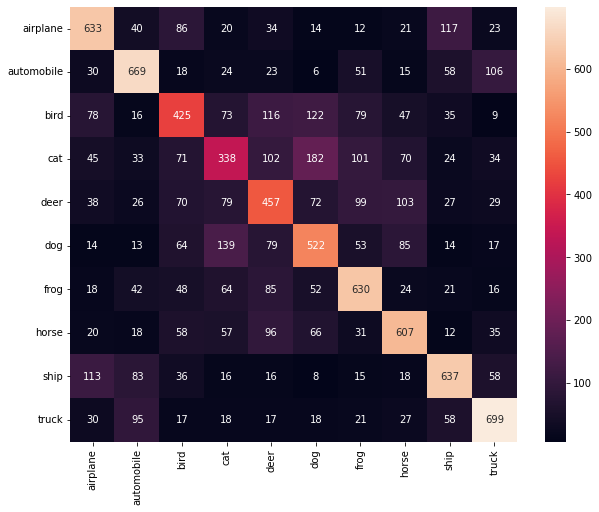

In [57]:
cm = confusion_matrix(Y_test.ravel(), Y_test_pred)
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])

## 7.4 Save Model

In [58]:
joblib.dump(model, '../saved-model/logistic-regression.joblib')

['../saved-model/logistic-regression.joblib']